<a href="https://colab.research.google.com/github/Salinastha37/mvc/blob/main/lstmforexhibition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


In [ ]:

# Read the CSV file
df = pd.read_csv("file.csv")

# Convert the Date column to a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Sort the dataframe by date
df = df.sort_values('Date')

# Convert '--' to 0 in the 'Percent Change' column
df['Percent Change'] = df['Percent Change'].replace('--', 0)

# Convert columns to float
df['Open'] = df['Open'].astype(float)
df['High'] = df['High'].astype(float)
df['Low'] = df['Low'].astype(float)
df['Close'] = df['Close'].astype(float)
df['Percent Change'] = df['Percent Change'].astype(float)

# Extract the 'Close' column for prediction
data = df['Close'].values.reshape(-1, 1)


In [ ]:

# Scale the data using Min-Max Scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define the training and testing data sizes
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size

# Split the data into training and testing sets
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size:, :]



In [ ]:

def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps - 7):
        X.append(data[i:i + time_steps, 0])
        y.append(data[i + time_steps:i + time_steps + 7, 0])
    return np.array(X), np.array(y)

# Define the number of time steps
time_steps = 7

# Prepare the training data
X_train, y_train = prepare_data(train_data, time_steps)

# Prepare the testing data
X_test, y_test = prepare_data(test_data, time_steps)

# Reshape the data for LSTM (samples, time_steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [ ]:

model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(time_steps, 1)))
model.add(Dropout(0.3))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=100))
model.add(Dense(units=7))  # Output layer with 7 units for predicting 7 days ahead
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 7, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 7)                 707       
                                                                 
Total params: 202,307
Trainable params: 202,307
Non-trai

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

Epoch 1/100
34/34 [==============================] - 10s 97ms/step - loss: 0.0307 - val_loss: 0.0025
Epoch 2/100
34/34 [==============================] - 1s 31ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 3/100
34/34 [==============================] - 1s 31ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 4/100
34/34 [==============================] - 1s 31ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 5/100
34/34 [==============================] - 1s 31ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 6/100
34/34 [==============================] - 1s 28ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 7/100
34/34 [==============================] - 1s 27ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 8/100
34/34 [==============================] - 1s 32ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 9/100
34/34 [==============================] - 1s 31ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 10/100
34/34 [==============================] - 1s 28ms/step - loss: 0.0025 - val_loss: 0.001

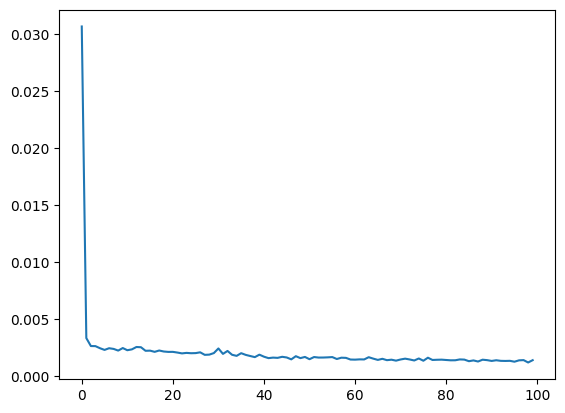

In [ ]:
loss = model.history.history['loss']
plt.plot(loss)

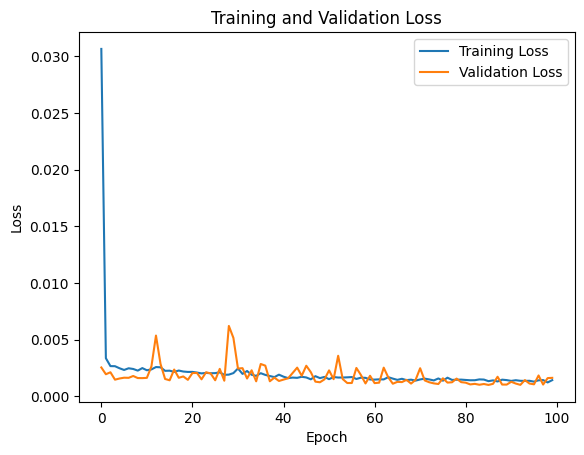

In [ ]:
# Extract the training and validation loss from the history
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 [==============================] - 0s 13ms/step


In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)


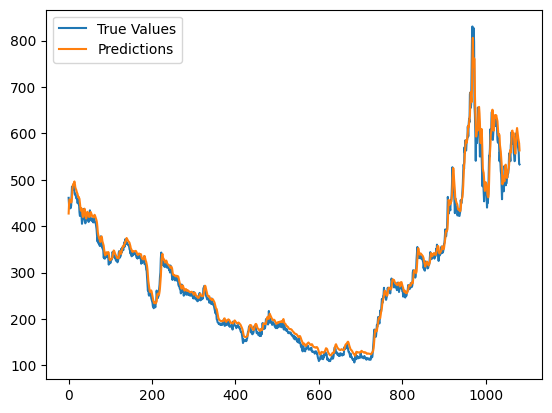

In [ ]:
y_train_one_day = y_train[:, 0]
train_predict_one_day = train_predict[:, 0]

plt.plot(y_train_one_day, label='True Values')
plt.plot(train_predict_one_day, label='Predictions')
plt.legend()
plt.show()

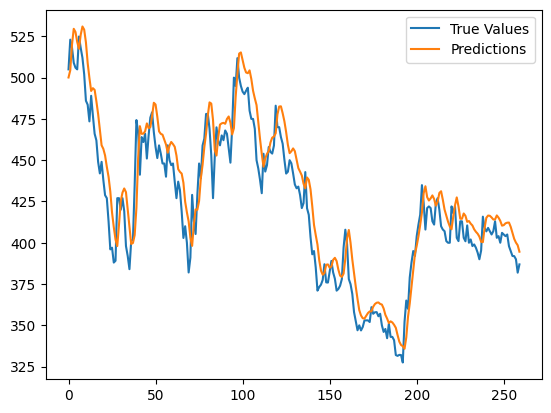

In [ ]:
y_test_one_day = y_test[:, 0]
test_predict_one_day = test_predict[:, 0]

plt.plot(y_test_one_day, label='True Values')
plt.plot(test_predict_one_day, label='Predictions')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error,r2_score

# Calculate RMSE and R2 for training data
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
train_r2 = r2_score(y_train, train_predict)

print("Training RMSE:", train_rmse)
print("Training R2:", train_r2)

# Calculate RMSE and R2 for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
test_r2 = r2_score(y_test, test_predict)
test_mae = mean_absolute_error(y_test, test_predict)
print("Testing MAE:", test_mae)
print("Testing RMSE:", test_rmse)
print("Testing R2:", test_r2)

Training RMSE: 25.293842698431504
Training R2: 0.9695992612862999
Testing MAE: 23.588428723681112
Testing RMSE: 29.192789912685644
Testing R2: 0.5350950035431111


In [ ]:

last_week_data = scaled_data[-time_steps:, :]
last_week_data = np.reshape(last_week_data, (1, time_steps, 1))
predictions = model.predict(last_week_data)
predictions = scaler.inverse_transform(predictions)
predicted_close_prices = predictions[0]

last_date = df['Date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=7, freq='D')
df_predictions = pd.DataFrame({'close_price': predicted_close_prices.flatten(), 'date': forecast_dates})

print(df_predictions)


1/1 [==============================] - 0s 25ms/step
   close_price       date
0   401.890961 2023-04-20
1   402.631866 2023-04-21
2   404.066345 2023-04-22
3   408.715790 2023-04-23
4   410.067993 2023-04-24
5   408.626465 2023-04-25
6   411.260590 2023-04-26
